# Libraries

In [1439]:
import pandas as pd
import datetime
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier 
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline



# Data cleaning and cration of some variables

In [1440]:
df = pd.read_csv('../data/show_no_show.csv', index_col='Unnamed: 0')

In [1441]:
df.dropna(inplace=True)

In [1442]:
df = df[df["Age"]>=0]

In [1443]:
df = df[df["Age"]<=110]

In [1444]:
df.reset_index(inplace=True)

## ScheduledDay & AppointmentDay into datetime

In [1447]:
df['ScheduledDay']=df['ScheduledDay'].apply(lambda ex: datetime.date(int(ex[0:4]), int(ex[5:7]), int(ex[8:10])))

In [1449]:
df['AppointmentDay']=df['AppointmentDay'].apply(lambda ex: datetime.date(int(ex[0:4]), int(ex[5:7]), int(ex[8:10])))

## Creation of Weekday

In [1451]:
df['WeekDay'] = df['AppointmentDay'].apply(lambda ex: ['lunes','martes','miércoles','jueves','viernes','sábado','domingo'][ex.weekday()])

## Calculation of days difference between scheduled day and appointment day

In [1453]:
df['DaysDifference']= df['AppointmentDay']-df['ScheduledDay']

In [1454]:
df['DaysDifference_Num'] = df['DaysDifference'].dt.days.astype('int16')

## Age into category

In [1455]:
def age_group(x):
    if x < 1:
        return 'baby'
    elif x < 13:
        return 'kid'
    elif x < 19:
        return 'teen'
    elif x < 35:
        return 'mid'
    elif x < 65:
        return 'adult'
    elif x < 85:
        return 'retired'
    else:
        return 'old'

In [1456]:
df["age_category"] = df["Age"].apply(age_group)

## Gender, alcoholism, attendance and neighborhood into 1 or 0

In [1457]:
df["Alcoholism_Num"] = df["Alcoholism"].replace("None", 0).replace("Low",1).replace("Moderate", 2).replace("High", 3)

In [1458]:
df["Attendance"] = df["No-show"].replace("No", 1).replace("Yes", 0) 

In [1459]:
df["No-show_Num"] = df["No-show"].replace("No", 0).replace("Yes", 1) 

In [1460]:
df["Gender_Num"] = df["Gender"].replace("M", 0).replace("F", 1) 

## Neighbourhood into numerical variable

In [1461]:
df_mean = df[["Neighbourhood","No-show_Num"]].groupby("Neighbourhood").mean("No-show_Num")

In [1462]:
df = df.join(df_mean, on = "Neighbourhood", rsuffix = "_Neighbourhood", how = "left")

## One hot encoder for age category and weekday

In [1465]:
enc = OneHotEncoder(handle_unknown='ignore')

### Encoder to Weekday

In [1466]:
enc.fit(X[['WeekDay']])
week_df = pd.DataFrame(enc.transform(X[['WeekDay']]).toarray(), columns= enc.get_feature_names(input_features = None))

In [1467]:
week_df.columns = week_df.columns.str.replace("x0_", "")

In [1468]:
df_new = pd.concat([df, week_df], axis= 1)

### Encoder to Age Category

In [1469]:
enc.fit(X[['age_category']])
age_cat = pd.DataFrame(enc.transform(X[['age_category']]).toarray(), columns= enc.get_feature_names(input_features = None))

In [1470]:
age_cat.columns = age_cat.columns.str.replace("x0_", "")

In [1471]:
df_new = pd.concat([df_new, age_cat], axis= 1)

# X and y definition

In [1472]:
X = df_new[['Gender_Num', 'Scholarship', 'Hipertension','Diabetes', 'Handcap', 'SMS_received', 'DaysDifference_Num', 'Alcoholism_Num', 'No-show_Num_Neighbourhood', 'lunes', 'martes', 'miércoles', 'jueves', 'viernes', 'sábado', 'adult', 'baby', 'kid', 'mid', 'old','retired', 'teen']]

In [ ]:
y = df['No-show_Num']

## Creation of our Train and Test samples

In [1473]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35)

# Model creation

## Gaussian

In [1474]:
GNB = GaussianNB()
model = GNB.fit(X, y)

In [1475]:
model.score(X, y) # Most of the "right answers" are due to the fact that we have so many zeroes in our target variable. The data set is imbalanced. 

0.7423409340834113

In [1476]:
y_pred = model.predict(X)
y_true = y

In [1477]:
#Check confussion matrix and calculate recall to see that, as suspected, we are only capturing 28.7% of the missing appointments
cm = confusion_matrix(y_true, y_pred)
recall = cm[1,1] / (cm[1,1] + cm[1,0])
recall

0.23157325644260227

## Dealing with imbalanced data set (undersampled)

### Near miss undersampling version 1

In [1478]:
nm1 = NearMiss(version = 1)

In [1479]:
X_res_neigh1, y_res_neigh1 = nm1.fit_resample(X, y)

In [1481]:
X_train_neigh1, X_test_neigh1, y_train_neigh1, y_test_neigh1 = train_test_split(X_res_neigh1, y_res_neigh1, test_size=0.35)

## Gaussian classifier

### With nearnest neighbors undersamling version 1

In [1482]:
GNB = GaussianNB()
model = GNB.fit(X_train_neigh1, y_train_neigh1)

In [1483]:
def GNB(X_train, X_test, y_train, y_test):
    GNB = GaussianNB()
    model = GNB.fit(X_train, y_train)
    scores = cross_val_score(GNB, X_test, y_test, cv = 10)
    return print(f'Using cross validation with 10 scores, we get an average of {round(scores.mean(),4)*100}%')

In [1484]:
GNB(X_train_neigh1, X_test_neigh1, y_train_neigh1, y_test_neigh1)

Using cross validation with 10 scores, we get an average of 62.3%


## Random forest 

### With near miss undersampling version 1

In [1485]:
# Score

def forest(X_train, X_test, y_train, y_test):
    forest = RandomForestClassifier(max_depth=4, random_state=45)
    model = forest.fit(X_train, y_train)
    scores = cross_val_score(forest, X_test, y_test, cv = 10)
    return print(f'Using cross validation with 10 scores, we get an average of {round(scores.mean(),3)*100}%')

In [1486]:
forest(X_train_neigh1, X_test_neigh1, y_train_neigh1, y_test_neigh1)

Using cross validation with 10 scores, we get an average of 78.2%


In [1487]:
# Feature importances

def forest(X_train, X_test, y_train, y_test):
    forest = RandomForestClassifier(max_depth=4, random_state=45)
    model = forest.fit(X_train, y_train)
    features = pd.DataFrame(model.feature_importances_, index= X.columns)
    return features

In [1488]:
forest(X_train_neigh1, X_test_neigh1, y_train_neigh1, y_test_neigh1)

,0
Gender_Num,0.008147
Scholarship,0.094214
Hipertension,0.051590
Diabetes,0.022491
Handcap,0.005478
SMS_received,0.142813
DaysDifference_Num,0.521450
Alcoholism_Num,0.018834
No-show_Num_Neighbourhood,0.080809
lunes,0.000710


In [1489]:
# Decission tree

def forest(X_train, X_test, y_train, y_test):
    forest = RandomForestClassifier(max_depth=4, random_state=45)
    model = forest.fit(X_train, y_train)
    fig = plt.figure(figsize=(15, 10))
    tree = plot_tree(model.estimators_[0], 
            feature_names=X.columns,
            class_names=["1","0"], 
            filled=True, impurity=True, 
            rounded=True)
    return tree

[Text(488.24999999999994, 489.24, 'Diabetes <= 0.5\ngini = 0.5\nsamples = 18204\nvalue = [14365, 14489]\nclass = 0'),
 Text(298.9285714285714, 380.52000000000004, 'Handcap <= 0.5\ngini = 0.5\nsamples = 17549\nvalue = [14244, 13587]\nclass = 1'),
 Text(159.42857142857142, 271.8, 'SMS_received <= 0.5\ngini = 0.499\nsamples = 17397\nvalue = [14227, 13335]\nclass = 1'),
 Text(79.71428571428571, 163.08000000000004, 'DaysDifference_Num <= 2.5\ngini = 0.476\nsamples = 11986\nvalue = [11655, 7445]\nclass = 1'),
 Text(39.857142857142854, 54.360000000000014, 'gini = 0.315\nsamples = 8330\nvalue = [10645, 2590]\nclass = 1'),
 Text(119.57142857142856, 54.360000000000014, 'gini = 0.285\nsamples = 3656\nvalue = [1010, 4855]\nclass = 0'),
 Text(239.1428571428571, 163.08000000000004, 'DaysDifference_Num <= 7.5\ngini = 0.423\nsamples = 5411\nvalue = [2572, 5890]\nclass = 0'),
 Text(199.28571428571428, 54.360000000000014, 'gini = 0.499\nsamples = 2028\nvalue = [1557, 1661]\nclass = 0'),
 Text(279.0, 54.

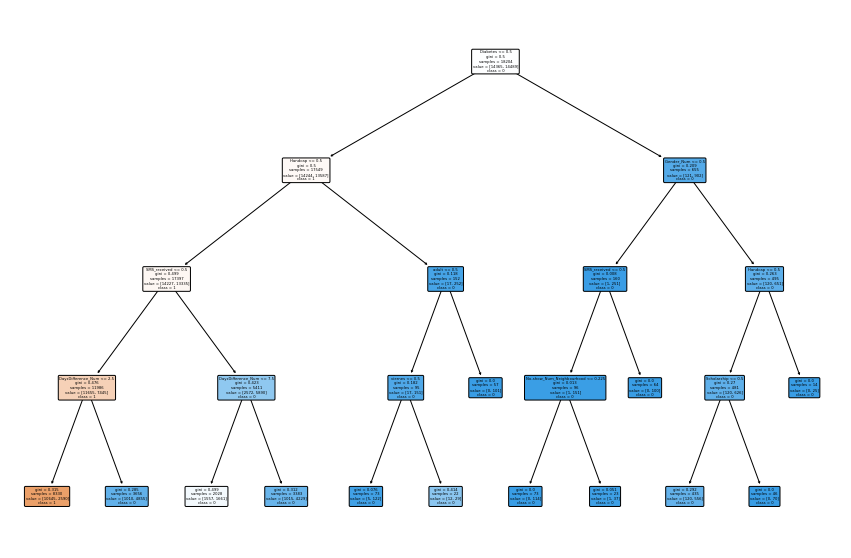

In [1490]:
forest(X_train_neigh1, X_test_neigh1, y_train_neigh1, y_test_neigh1)

In [1497]:
# Confussion matrix 

def forest(X_train, X_test, y_train, y_test):
    forest = RandomForestClassifier(max_depth=4, random_state=45)
    model = forest.fit(X_train, y_train)
    y_pred = model.predict(X_test_neigh1)
    y_true = y_test_neigh1
    cm = confusion_matrix(y_true, y_pred)
    recall = (round(cm[1,1] / (cm[1,1] + cm[1,0]),3))*100
    return print(f'The recall we get is {recall}%')

In [1498]:
forest(X_train_neigh1, X_test_neigh1, y_train_neigh1, y_test_neigh1)

The recall we get is 82.5%


## MLPC Classifier


In [1407]:
# MLPC Model

def MLPC(X_train, X_test, y_train, y_test):
    clf = MLPClassifier(solver='adam',
                    max_iter=1000,
                    alpha=1e-3,
                    activation='relu',
                    hidden_layer_sizes=(7,7,3))
    model = clf.fit(X_train, y_train)
    scores = cross_val_score(clf, X_test, y_test, cv = 10)
    return print(f'Using cross validation with 10 scores, we get an average of {round(scores.mean(),3)*100}%')



In [1408]:
MLPC(X_train_neigh1, X_test_neigh1, y_train_neigh1, y_test_neigh1)

Using cross validation with 10 scores, we get an average of 81.39999999999999%


In [1409]:
def MLPC(X_train, X_test, y_train, y_test):
    clf = MLPClassifier(solver='adam',
                    max_iter=1000,
                    alpha=1e-3,
                    activation='relu',
                    hidden_layer_sizes=(7,7,3))
    model = clf.fit(X_train, y_train)
    y_pred = model.predict(X_test_neigh1)
    y_true = y_test_neigh1
    cm = confusion_matrix(y_true, y_pred)
    recall = (round(cm[1,1] / (cm[1,1] + cm[1,0]),3))*100
    return print(f'The recall we get is {recall}%')

In [1410]:
MLPC(X_train_neigh1, X_test_neigh1, y_train_neigh1, y_test_neigh1)

The recall we get is 78.8%


## XGBOOST

In [1424]:
# XGBOOST Model

def XGB(X_train, X_test, y_train, y_test):
    XGB = XGBClassifier()
    model = XGB.fit(X_train, y_train)
    scores = cross_val_score(XGB, X_test, y_test, cv = 10)
    return print(f'Using cross validation with 10 scores, we get an average of {round(scores.mean(),3)*100}%')

In [1425]:
XGB(X_train_neigh1, X_test_neigh1, y_train_neigh1, y_test_neigh1)

/Users/miquicampuzano/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[08:39:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
/Users/miquicampuzano/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will

In [1426]:
def XGB(X_train, X_test, y_train, y_test):
    XGB = XGBClassifier()
    model = XGB.fit(X_train, y_train)
    y_pred = model.predict(X_test_neigh1)
    y_true = y_test_neigh1
    cm = confusion_matrix(y_true, y_pred)
    recall = (round(cm[1,1] / (cm[1,1] + cm[1,0]),3))*100
    return print(f'The recall we get is {recall}%')

In [1427]:
XGB(X_train_neigh1, X_test_neigh1, y_train_neigh1, y_test_neigh1)

[08:39:44] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The recall we get is 81.0%
